# 401 Assignment 2

In [36]:
# imports
import math
import random
import numpy as np
import torch
import torchvision
import torchvision.transforms
import torch.optim
import torch.utils.data.sampler
import torch.nn.functional
import matplotlib.pyplot as plt


# settings

random.seed(55)

## 1. Gradient-based Learning with Tensors

### Defining R<sup>5</sup> to R<sup>4</sup> Function
The definition of the function with noise added is done in create_output_tensor_noisy. This takes a tensor input of
with many different 5 value tuples and returns the output for all the tuples passed in.
The R<sup>5</sup> to R<sup>4</sup> is defined by multiplying the input with a predefined weight matrix to apply
a linear change.
 

In [37]:
def create_output_tensor_noisy(input, weights):
    tensor_a = input#torch.from_numpy(input)
    tensor_b = torch.from_numpy(weights)
    output = tensor_a.t()@tensor_b.t()
    noise = np.random.normal(loc=0, scale=0.01, size=np.shape(input.size))
    output = output + torch.from_numpy(noise)
    return output

### Training
We then train the network using tensor operations, our prediction / model is defined as transpose of input (x) matrix multiplied by
the transpose of our current weight matrix then the addition of our biases.
We calculate our loss using Mean Square Error (mse).

In [38]:
def mse(in1, in2):
    diff = in1 - in2
    return torch.sum(diff*diff) / diff.numel()

def model(x,w,b):
    return x.t() @ w.t() +b

def train(input, target, w, b, i, learning_rate=1e-2):
    prediction = model(input, w,b)
    loss = mse(prediction, target)
    if i % 50 == 0:
        print("epoch " + str(i) + " loss = " + str(loss.item()))
    loss.backward(retain_graph=True)
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

def test(input, target, w, b):
    prediction = model(input, w, b)
    print('Expected:')
    print(target.data.numpy())
    print('Prediction:')
    print(prediction.data.numpy())
    return prediction



eqtn = np.array([[3.7, 2.3, 1, 0, 5],
      [4.7, 8.1, 2.5,  0, 25],
      [2.7, 1, 9, 3.9, 0],
      [5.2, 6, 2, 0, 0]], dtype=np.float32)
tensor_in = torch.randn(5,1000, requires_grad=True)
tensor_target = create_output_tensor_noisy(tensor_in, eqtn)     
weights = torch.randn(4,5, requires_grad=True)
biases = torch.randn(4, requires_grad=True)
q1_epochs = 1000
for i in range(1,q1_epochs+1):
    train(input= tensor_in, target= tensor_target, w = weights, b = biases, i = i)
    

epoch 50 loss = 145.0626678466797
epoch 100 loss = 87.76795196533203
epoch 150 loss = 53.14679718017578
epoch 200 loss = 32.2093505859375
epoch 250 loss = 19.53679084777832
epoch 300 loss = 11.860227584838867
epoch 350 loss = 7.206164836883545
epoch 400 loss = 4.38214635848999
epoch 450 loss = 2.667125701904297
epoch 500 loss = 1.624706506729126
epoch 550 loss = 0.9905685186386108
epoch 600 loss = 0.6044605374336243
epoch 650 loss = 0.3691716492176056
epoch 700 loss = 0.22566187381744385
epoch 750 loss = 0.13805672526359558
epoch 800 loss = 0.08453349024057388
epoch 850 loss = 0.051804788410663605
epoch 900 loss = 0.031775105744600296
epoch 950 loss = 0.019505921751260757
epoch 1000 loss = 0.011984015814960003


We can see that after 1000 epochs over 1000 points of data the loss has been reduced to ~0.02

Looking at a test we can see that the predicted values closely match what we expected, going further we can look at
the final weights of the linear regression and compare them to the weights in the equation. Doing so we see that the 
found weights are very close to those defined by the equation showing that our network has found the correct linear
regression formula.

In [39]:
tensor_test_in = torch.randn(5,5, requires_grad=True)
tensor_test_target = create_output_tensor_noisy(tensor_test_in, eqtn)  
q1_test_pred = test(tensor_test_in, tensor_test_target, weights, biases)
print('**********')
print('Final MSE:')
print(mse(q1_test_pred, tensor_test_target).item())

print('**********')
print('Known Linear Weights:')
print(eqtn)
print('****')
print('Found Linear Weights:')
print(weights)
print('**********')


Expected:
[[ -7.4428926  -38.913074    -1.7586278   -2.2090292 ]
 [ -5.118244   -29.241888     9.813749    -0.224538  ]
 [-10.617767   -30.292315    -2.3416739   -7.87937   ]
 [ -0.35137793  13.210859    -6.2580247   -4.7699285 ]
 [ 14.668304    52.167725     7.780567    12.209192  ]]
Prediction:
[[ -7.3812656  -38.663876    -1.7617525   -2.1954117 ]
 [ -5.054283   -29.028471     9.762396    -0.17814192]
 [-10.509813   -30.046555    -2.306144    -7.749305  ]
 [ -0.31747383  13.173671    -6.2280655   -4.740524  ]
 [ 14.591275    51.835976     7.673927    12.030138  ]]
**********
Final MSE:
0.018723517656326294
**********
Known Linear Weights:
[[ 3.7  2.3  1.   0.   5. ]
 [ 4.7  8.1  2.5  0.  25. ]
 [ 2.7  1.   9.   3.9  0. ]
 [ 5.2  6.   2.   0.   0. ]]
****
Found Linear Weights:
tensor([[ 3.6637e+00,  2.2804e+00,  1.0086e+00,  5.8867e-03,  4.9711e+00],
        [ 4.6428e+00,  8.0276e+00,  2.5020e+00,  9.7619e-03,  2.4854e+01],
        [ 2.6886e+00,  9.7735e-01,  8.9100e+00,  3.8931e+00,

## 2. Transfer Learning


### MNIST

Transfer learning starts with the creation of a CNN for MNIST dataset, where we are able to train it to 99% correctness
in one epoch of the 60,000 point dataset. This is a large increase from the 6% accuracy it has before training.

Our CNN is defined in the class MNISTCNN which extends pytorch's Module class, providing the underlying logic for many
CNN operations, allowing us to better define parameters such as inputs, layers and the forward function.

In [40]:
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)

class MNISTCNN(torch.nn.Module):
    def __init__(self):
        super(MNISTCNN,self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.drop_out = torch.nn.Dropout()
        self.fc1 = torch.nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = torch.nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

 Next we train and test the CNN with the functions below. These functions iterate through the training and test loaders
 that are passed in, updating the model at each step. The training will then determine the loss between the prediction
 and target, using this and the loss function to update weights and biases accordingly at loss.backwards()

In [59]:
def train_net(mnist_model, device, train_loader, optimizer, loss_func, epoch):
    mnist_model.train()
    train_loss = 0
    count = 0
    for i, (data, target) in enumerate(train_loader):
        count += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = mnist_model(data)
        loss = loss_func(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i , len(train_loader),
                100. * i / len(train_loader), loss.item()))
    print('\nTraining Set: Average loss: {:.4f}'.format(
        train_loss/ count))
    return train_loss/count

def test_net(mnist_model, device, test_loader, loss_func):
    mnist_model.eval()
    test_loss = 0
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            count += 1
            data, target = data.to(device), target.to(device)
            output = mnist_model(data)
            _, pred = torch.max(output.data,1)
            test_loss += loss_func(output, target).item() # sum up batch loss
            correct += pred.eq(target).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    #print(count)
    return correct / len(test_loader.dataset)



In [48]:
batch_size = 64
train_batch_size = 64
test_batch_size = 100
mnist_epochs = 1
device = torch.device("cpu")
learning_rate = 1e-3

train_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('./data', train=True, download=True,
               transform=torchvision.transforms.transforms.Compose([
                   torchvision.transforms.transforms.ToTensor(),
                   torchvision.transforms.transforms.Normalize((0.1307,), (0.3081,))
               ])),
            batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST('./data', train=False, transform=torchvision.transforms.transforms.Compose([
                torchvision.transforms.transforms.ToTensor(),
                torchvision.transforms.transforms.Normalize((0.1307,), (0.3081,))
            ])),
            batch_size=batch_size, shuffle=False)

mnist_model = MNISTCNN().to(device)
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

print("Before Training")
test_net(mnist_model,device,test_loader,loss_func)
print("Training model with:")
print("batch size = " + str(train_batch_size))
print("learning rate = " + str(learning_rate))
print("over " + str(mnist_epochs) + " epochs")
for epoch in range(1, mnist_epochs + 1):
    train_net(mnist_model, device, train_loader, optimizer, loss_func, epoch)
    test_net(mnist_model, device, test_loader, loss_func)

Before Training

Test set: Average loss: 0.0364, Accuracy: 771/10000 (8%)

157
Training model with:
batch size = 64
learning rate = 0.001
over 1 epochs
Train Epoch: 1 [0/938 (0%)]	Loss: 2.329604
Train Epoch: 1 [100/938 (11%)]	Loss: 0.184255
Train Epoch: 1 [200/938 (21%)]	Loss: 0.143383
Train Epoch: 1 [300/938 (32%)]	Loss: 0.230341
Train Epoch: 1 [400/938 (43%)]	Loss: 0.054007
Train Epoch: 1 [500/938 (53%)]	Loss: 0.041256
Train Epoch: 1 [600/938 (64%)]	Loss: 0.083377
Train Epoch: 1 [700/938 (75%)]	Loss: 0.017259
Train Epoch: 1 [800/938 (85%)]	Loss: 0.140233
Train Epoch: 1 [900/938 (96%)]	Loss: 0.031264

Training Set: Average loss: 0.1631

Test set: Average loss: 0.0007, Accuracy: 9860/10000 (99%)

157


### CIFAR10
To complete transfer learning we have to create a compatible CNN for our second data set, CIFAR10. This requires some
form of transformation of the data as the data sets include images of different sizes and channels.
This transformation can be seen in the transform variable below, where we use the Compose function to add several 
transforms including resizing the image and making it greyscale  so it has the same input parameters as the MNIST
dataset.

Changing the CIFAR10 dataset images to black and white to match the MNIST dataset was done as it is generally easier
to convert an image to greyscale then to

In [74]:
seed = 55
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cpu")

class CIFARCNN(torch.nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18*16*16, 64)
        self.fc2 = torch.nn.Linear(64, 10)
    def forward(self, x_val):
        x_val = torch.nn.functional.relu(self.conv1(x_val))
        x_val = self.pool(x_val)
        x_val = x_val.view(-1, 18 * 16 * 16)
        x_val = torch.nn.functional.relu(self.fc1(x_val))
        x_val = self.fc2(x_val)
        return x_val

cifar_epoch = 10
transform_cifar_to_mnist = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=28),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_set_cifar_to_mnist = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar_to_mnist)
test_set_cifar_to_mnist = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar_to_mnist)

transform_cifar = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set_cifar= torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_set_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)




# classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Training
n_training_samples = 50000
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
#Test
n_test_samples = 10000
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))


cifar_test_loader = torch.utils.data.DataLoader(test_set_cifar, batch_size=4, sampler=test_sampler, num_workers=2)
cifar_train_loader = torch.utils.data.DataLoader(train_set_cifar, batch_size=64,sampler=train_sampler, num_workers=2)

cifar_to_mnist_test_loader = torch.utils.data.DataLoader(test_set_cifar_to_mnist, batch_size=4, sampler=test_sampler, num_workers=2)
cifar_to_mnist_train_loader = torch.utils.data.DataLoader(train_set_cifar_to_mnist, batch_size=64,sampler=train_sampler, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Once we have loaded the data sets in the correct form we can move onto training the model using our existing CNN
class. We do this with both a new model and one that has had its first layer transferred from our earlier MNIST model
so that we can compare results.

In [75]:
cifar_model = CIFARCNN().to(device)
cifar_optimizer = torch.optim.Adam(cifar_model.parameters(), lr=learning_rate)
cifar_loss_func = torch.nn.CrossEntropyLoss()


cifar_model_transfer = MNISTCNN().to(device)
cifar_model_transfer.layer1 = mnist_model.layer1
cifar_model_transfer.layer2 = mnist_model.layer2
cifar_transfer_optimizer = torch.optim.Adam(cifar_model_transfer.parameters(), lr=learning_rate)
cifar_transfer_loss_func = torch.nn.CrossEntropyLoss()

cifar_acc = []
cifar_train_loss = []
for epoch in range(1, cifar_epoch + 1):
    cifar_train_loss.append(train_net(cifar_model, device, cifar_train_loader, cifar_optimizer, loss_func, epoch))
    cifar_acc.append(test_net(cifar_model, device, cifar_test_loader, loss_func))

cifar_transfer_acc = []
cifar_transfer_train_loss = []
for epoch in range(1, cifar_epoch + 1):
    cifar_transfer_train_loss.append(train_net(cifar_model_transfer, device, cifar_to_mnist_train_loader, cifar_transfer_optimizer, cifar_transfer_loss_func, epoch))
    cifar_transfer_acc.append(test_net(cifar_model_transfer, device, cifar_to_mnist_test_loader, cifar_transfer_loss_func))
    

Train Epoch: 1 [0/782 (0%)]	Loss: 2.291676
Train Epoch: 1 [100/782 (13%)]	Loss: 1.669757
Train Epoch: 1 [200/782 (26%)]	Loss: 1.436748
Train Epoch: 1 [300/782 (38%)]	Loss: 1.390168
Train Epoch: 1 [400/782 (51%)]	Loss: 1.443785
Train Epoch: 1 [500/782 (64%)]	Loss: 1.383302
Train Epoch: 1 [600/782 (77%)]	Loss: 1.307558
Train Epoch: 1 [700/782 (90%)]	Loss: 1.322692

Training Set: Average loss: 1.4490

Test set: Average loss: 0.3160, Accuracy: 5467/10000 (55%)

Train Epoch: 2 [0/782 (0%)]	Loss: 1.290075
Train Epoch: 2 [100/782 (13%)]	Loss: 1.323254
Train Epoch: 2 [200/782 (26%)]	Loss: 1.096234
Train Epoch: 2 [300/782 (38%)]	Loss: 1.365171
Train Epoch: 2 [400/782 (51%)]	Loss: 1.030478
Train Epoch: 2 [500/782 (64%)]	Loss: 1.208444
Train Epoch: 2 [600/782 (77%)]	Loss: 1.124928
Train Epoch: 2 [700/782 (90%)]	Loss: 1.006148

Training Set: Average loss: 1.1644

Test set: Average loss: 0.2881, Accuracy: 5912/10000 (59%)

Train Epoch: 3 [0/782 (0%)]	Loss: 0.868991
Train Epoch: 3 [100/782 (13%)]	Lo

The graph below shows the accuracy each epoch of the two CNNs

Accuracy of networks over epochs


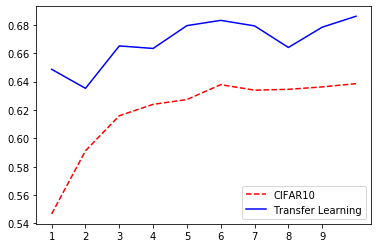

In [77]:
# GRAPH HERE    
print("Accuracy of networks over epochs")
plt.plot(cifar_acc,'r--', label='CIFAR10')
plt.plot(cifar_transfer_acc, 'b-', label='Transfer Learning')
plt.legend()
plt.xticks(list(range(0,9)), list(range(1,10)))
plt.show()

The graph below shows the average training loss each epoch of the two CNNs

**********
Average training loss over epochs


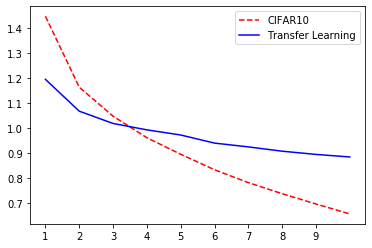

In [76]:
print("**********")
print("Average training loss over epochs")
plt.plot(cifar_train_loss,'r--', label='CIFAR10')
plt.plot(cifar_transfer_train_loss, 'b-', label='Transfer Learning')
plt.legend()
plt.xticks(list(range(0,9)), list(range(1,10)))
plt.show()

### Discussion
In the graph above it is clearly shown that the transfered network (blue squares) performs better than the standard 
CIFAR10 CNN, this is especially noticeable in early iterations where the transferred layers from the MNIST set give a 
clear a advantage to the transfer learning CNN.

The decrease in training loss over time shows the models are getting better at predicting the training set, we can also
see that the CIFAR CNN trends much lower, this means that it is creating a 'better' model, however we can see from the
accuracy above that the transfer learning out performs it, meaning that the CIFAR CNN is likely over-fitting the data
more than the transfer learning cnn.


## 3. Cost-Sensitive Learning (Option A)

### 3.1 Pseudo code for loss function
The loss can be defined as the absolute difference from the correct case where the prediction is right and the case of
the prediction being wrong. Therefore the more incorrect a prediction the higher the loss value would be.

In [46]:
#Python Pseudo Code (Not runnable)
C = [[],[]] #cost matrix
def q3_loss(pred, target):
    if pred == target: 
        # the case of a correct classification
        return 0
    else:
        math.fabs(C[target, target]- C[target, pred])
         

### 3.2 Different way given learning algorithm
Assuming we cannot supply our own loss function we could modify the inputs to the learning algorithm with these
expected costs. Matrix multiplication would allow for a changing of the underlying weights before the input is
put into the learning algorithm.

q3_input = dataset @ C<br>
learning_algorithm(q3_input)<br>
